In DLS the intensity of light scattering is proportional to the molecular weight squared multiplied by the concentration of the scatterer. The diffusion constant measured is therefore a weighted average.

$D_z = \frac{\sum_{i} M^2_i c_i D_{T,i}}{\sum_{i} M^2_i c_i}$

$R_h$ is calculated according to stokes einstein.

$R_h = \frac{k_B T}{6 \pi \eta D_T}$

The average $R_h$ is therefore

$R_{avg} = \frac{\sum_{i} M^2_i c_i}{\sum_{i} M^2_i c_i /R_i}$

In the case of a monomer to trimer

$M + M + M <--> T$

And $ K_a = \frac{[T]}{[M]^3} $

$C_{tot} = M + 3T$

$0 = 3K_aM^3 + M - C{tot}$

$a = 3K_a$

$c = 1$

$d = -C_{tot}$

In the case of monomer-trimer-hexamer

$C_{tot} = M + 3T + 6H$

$K_{a1} = \frac{T}{M^3}$

$K_{a2} = \frac{H}{T^2}$

$T = K_{a1}M^3$

$H = K_{a2}K_{a1}^2M^6$

As a 6th order polynomial...

$0 = ax^6 + bx^5 + cx^4 + dx^3 + ex^2 + fx + g$

$a=6K_{a2}K_{a1}^2$

$d=3K_{a1}$

$f=1$

$g=-C_{tot}$


Fortunately there is a function in numpy for solving roots of polynomials


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import roots, exp

from lmfit import Model

from dls.dls import stokes_einstein, viscosity

In [180]:
def vanthoff(dH,dS,T,R=8.314):
    """ Van't hoff equation 
        
        Arguments
        ---------
        
        dH -- enthalpy
        dS -- entropy
        T -- temperature in kelvin
        R -- gas constant
        
        returns
        -------
        
        k_eq -- equilibrium constant
        
    """
    return exp(-dH/(R*T) + dS/R)

def r_avg(M,c,Rh):
    return np.sum(M ** 2. * c) / np.sum(M ** 2. * c / Rh)
    
def d_avg(M,c,D):
    return np.sum(M ** 2. * c * D) / np.sum(M ** 2. * c)
    
def mon_tri(CT, Rh1, Rh2, dH, dS):

    # relative masses
    M1 = 1.
    M2 = 3.
    # concentration and temperature
    C = CT[:, 0]
    T = CT[:, 1]
    # association constant
    K_eq = vanthoff(dH,dS,T)
    
    #print("K_eq")
    #print(1./K_eq)
    # coeffs
    a = 3.0 * K_eq
    b = 0.0
    c = 1.0
    d = -C
    # a and d will be arrays
    roots = np.array([np.roots([a_i, b, c, d_i]) for a_i, d_i in zip(a, d)])
    
    # get real positive
    roots = np.real(roots[np.where((np.imag(roots) == 0) & (np.real(roots) > 0))])
    #print("Real roots",roots)
    # concentrations of monomer
    C_monomer = roots
    # concentrations of trimer
    C_trimer = roots ** 3.0 * K_eq
    
    # calculate average Rh
    M = np.array([M1,M2])
    c = np.array([C_monomer,C_trimer])
    Rh = np.array([Rh1,Rh2])
    R_avg = ((M1**2*C_monomer)+(M2**2*C_trimer)) / ((M1**2*C_monomer/Rh1)+(M2**2*C_trimer/Rh2))
    #R_avg = r_avg(M,c,Rh)

    return R_avg

def tri_hex(CT, Rh1, Rh2, dH, dS):

    # relative masses
    M1 = 1.
    M2 = 2.
    # concentration and temperature
    C = CT[:, 0]
    T = CT[:, 1]
    # association constant
    K_eq = vanthoff(dH,dS,T)
    
    #print("K_eq")
    #print(1./K_eq)
    # coeffs
    a = K_eq
    b = 1.0
    c = -C
    # a and d will be arrays
    roots = np.array([np.roots([a_i, b, c_i]) for a_i,c_i in  zip(a,c)])
    #print("Real roots",roots)
    # get real positive
    roots = np.real(roots[np.where((np.imag(roots) == 0) & (np.real(roots) > 0))])

    # concentrations of monomer
    C_trimer = roots
    # concentrations of trimer
    C_hexamer = roots ** 2.0 * K_eq
    
    # calculate average Rh
    M = np.array([M1,M2])
    c = np.array([C_trimer,C_hexamer])
    Rh = np.array([Rh1,Rh2])
    R_avg = ((M1**2*C_trimer)+(M2**2*C_hexamer)) / ((M1**2*C_trimer/Rh1)+(M2**2*C_hexamer/Rh2))
    #R_avg = r_avg(M,c,Rh)

    return R_avg

def mon_tri_hex(CT, Rh1, Rh2, Rh3, dH1, dS1, dH2, dS2):

    # relative masses
    M1 = 1.
    M2 = 3.
    M3 = 6.
    
    # concentration and temperature
    C = CT[:, 0]
    T = CT[:, 1]
    
    # association constant
    K_eq1 = vanthoff(dH1,dS1,T)
    K_eq2 = vanthoff(dH2,dS2,T)
    
    # coeffs
    a = 6.0 * K_eq1**2 * K_eq2
    b = 0.0
    c = 0.0
    d = 3 * K_eq1 
    e = 0.0
    f = 1.0
    g = -C
    # a and d will be arrays
    roots = np.array([np.roots([a_i, b, c, d_i, e, f, g_i]) for a_i, d_i, g_i in zip(a, d, g)])
    # get real positive
    roots = np.real(roots[np.where((np.imag(roots) == 0) & (np.real(roots) > 0))])
    
    # concentrations of monomer
    C_monomer = roots
    # concentrations of trimer
    C_trimer = roots ** 3.0 * K_eq1
    # concentrations of hexamer
    C_hexamer = roots ** 6.0 * K_eq1**2 * K_eq2
    
    # calculate average Rh
    #M = np.array([M1, M2, M3])
    #c = np.array([C_monomer, C_trimer, C_hexamer]).T
    #Rh = np.array([Rh1 , Rh2, Rh3])
    
    #R_avg = r_avg(M,c,Rh)
    R_avg = ((M1**2*C_monomer)+(M2**2*C_trimer)+(M3**2*C_hexamer)) / ((M1**2*C_monomer/Rh1)+(M2**2*C_trimer/Rh2)+(M3**2*C_hexamer/Rh3))
    #print(R_avg)
    return R_avg

def tri_hex_dod(CT, Rh1, Rh2, Rh3, dH1, dS1, dH2, dS2):

    # relative masses
    M1 = 1.
    M2 = 3.
    M3 = 6.
    
    # concentration and temperature
    C = CT[:, 0]
    T = CT[:, 1]
    
    # association constant
    K_eq1 = vanthoff(dH1,dS1,T)
    K_eq2 = vanthoff(dH2,dS2,T)
    
    # coeffs
    a = 4.0 * K_eq1**2 * K_eq2
    b = 0.0
    c = 2.0 * K_eq1 
    d = 1.0
    e = -C
    # a and d will be arrays
    roots = np.array([np.roots([a_i, b, c_i, d, e_i]) for a_i, c_i, e_i in zip(a, c, e)])
    # get real positive
    roots = np.real(roots[np.where((np.imag(roots) == 0) & (np.real(roots) > 0))])
    
    # concentrations of monomer
    C_trimer = roots
    # concentrations of hexamer
    C_hexamer = C_trimer ** 2.0 * K_eq1
    # concentrations of dodecamer
    C_dodecamer = C_hexamer ** 2.0 * K_eq2
    
    # calculate average Rh
    #M = np.array([M1, M2, M3])
    #c = np.array([C_monomer, C_trimer, C_hexamer]).T
    #Rh = np.array([Rh1 , Rh2, Rh3])
    
    #R_avg = r_avg(M,c,Rh)
    R_avg = ((M1**2*C_trimer)+(M2**2*C_hexamer)+(M3**2*C_dodecamer)) / ((M1**2*C_trimer/Rh1)+(M2**2*C_hexamer/Rh2)+(M3**2*C_dodecamer/Rh3))
    #print(R_avg)
    return R_avg

def init_fit(CT ,Rh1, Rh2, Rh3, dG1, dG2):
    # relative masses
    M1 = 1.
    M2 = 3.
    M3 = 6.
    # concentration and temperature
    C = CT[:, 0]
    T = CT[:, 1]
    
    R=8.314
    # association constant
    K_eq1 = np.exp(-dG1/(R*T))
    K_eq2 = np.exp(-dG2/(R*T))
    
    # coeffs
    a = 4.0 * K_eq1**2 * K_eq2
    b = 0.0
    c = 2.0 * K_eq1 
    d = 1.0
    e = -C
    # a and d will be arrays
    roots = np.array([np.roots([a_i, b, c_i, d, e_i]) for a_i, c_i, e_i in zip(a, c, e)])
    # get real positive
    roots = np.real(roots[np.where((np.imag(roots) == 0) & (np.real(roots) > 0))])
    
    # concentrations of monomer
    C_trimer = roots
    # concentrations of hexamer
    C_hexamer = C_trimer ** 2.0 * K_eq1
    # concentrations of dodecamer
    C_dodecamer = C_hexamer ** 2.0 * K_eq2
    
    # calculate average Rh
    #M = np.array([M1, M2, M3])
    #c = np.array([C_monomer, C_trimer, C_hexamer]).T
    #Rh = np.array([Rh1 , Rh2, Rh3])
    
    #R_avg = r_avg(M,c,Rh)
    R_avg = ((M1**2*C_trimer)+(M2**2*C_hexamer)+(M3**2*C_dodecamer)) / ((M1**2*C_trimer/Rh1)+(M2**2*C_hexamer/Rh2)+(M3**2*C_dodecamer/Rh3))
    #print(R_avg)
    return R_avg

# Read data

In [188]:
data = pd.read_csv("190404_degQ_1_melt_2_fits.csv")

# list of tuples (row,columns,concentration,pH)
wells = [
    ("B", [7, 8, 9], 3.75, 7.2),
    ("B", [10, 11, 12], 7.5, 7.2),
    ("B", [13, 14, 15], 11.25, 7.2),
    ("B", [16, 17, 18], 15, 7.2),
    ("B", [19, 20, 21], 30, 7.2),
    ("B", [22, 23, 24], 45, 7.2),
    ("C", [1, 2, 3], 60, 7.2),
    ("C", [4, 5, 6], 75, 7.2),
    ("C", [7, 8, 9], 120, 7.2),
    ("C", [10, 11, 12], 240, 7.2),
    ("C", [13, 14, 15], 450, 7.2),
    ("C", [16, 17, 18], 600, 7.2),
]

#  make well, temperature and conc columns
data["well"] = data.col.apply(lambda x: x.split("_")[0])
data["temperature"] = data.col.apply(lambda x: round(float(x.split("_")[1][:-4]))+273.15) # convert to K
data["conc"] = 0.0
data["pH"] = 0.0
# correct Rh for temperature in K
data["Rh"] = data.apply(
    lambda x: stokes_einstein(
        x.D, viscosity(x.temperature), x.temperature
    ),
    axis=1,
)

for v in wells:
    #print([nu for nu in v[0]])
    w = [f"{v[0]}{nu}" for nu in v[1]]
    #print(wells)
    conc = v[2]
    data.loc[data.well.isin(w),"conc"] = conc * 1e-6 # convert to molar


In [189]:
data = data[data.conc!=0]
#data = data[data.temperature==293.15]
data

,D,D_err,B,B_err,beta,beta_err,mu_2,mu_2_err,col,Gamma,PD,Rh,Rh_err,well,temperature,conc,pH
24,3.190000e-11,1.290000e-13,1.0,0.000020,0.0676,0.000056,31800000.0,1660000.0,B7_20.0(C),12300.0,0.20900,6.719275e-09,3.090000e-11,B7,293.15,0.000004,0.0
25,3.320000e-11,1.210000e-13,1.0,0.000028,0.1080,0.000081,19500000.0,1640000.0,B8_20.0(C),12800.0,0.11900,6.456171e-09,2.710000e-11,B8,293.15,0.000004,0.0
26,3.240000e-11,1.760000e-13,1.0,0.000020,0.0503,0.000056,37100000.0,2300000.0,B9_20.0(C),12500.0,0.23600,6.615582e-09,4.100000e-11,B9,293.15,0.000004,0.0
27,3.070000e-11,4.850000e-14,1.0,0.000012,0.1020,0.000033,10000000.0,616000.0,B10_20.0(C),11900.0,0.07110,6.981918e-09,1.260000e-11,B10,293.15,0.000007,0.0
28,3.070000e-11,4.820000e-14,1.0,0.000015,0.1290,0.000041,8350000.0,612000.0,B11_20.0(C),11800.0,0.05950,6.981918e-09,1.260000e-11,B11,293.15,0.000007,0.0
29,3.120000e-11,5.530000e-14,1.0,0.000018,0.1430,0.000052,7910000.0,714000.0,B12_20.0(C),12100.0,0.05430,6.870028e-09,1.390000e-11,B12,293.15,0.000007,0.0
30,3.080000e-11,4.770000e-14,1.0,0.000017,0.1540,0.000048,4820000.0,610000.0,B13_20.0(C),11900.0,0.03410,6.959249e-09,1.230000e-11,B13,293.15,0.000011,0.0
31,3.050000e-11,4.170000e-14,1.0,0.000012,0.1160,0.000032,3680000.0,529000.0,B14_20.0(C),11800.0,0.02650,7.027701e-09,1.100000e-11,B14,293.15,0.000011,0.0
32,3.020000e-11,5.460000e-14,1.0,0.000020,0.1560,0.000056,-7040000.0,698000.0,B15_20.0(C),11700.0,-0.05170,7.097512e-09,1.470000e-11,B15,293.15,0.000011,0.0
33,3.080000e-11,3.990000e-14,1.0,0.000015,0.1580,0.000041,5800000.0,511000.0,B16_20.0(C),11900.0,0.04090,6.959249e-09,1.030000e-11,B16,293.15,0.000015,0.0


(245,)
(245,)
(245,)


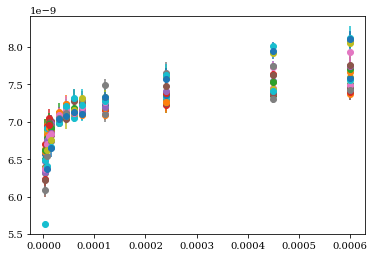

In [190]:
Ts = []
concs = []
Rhs = []
Rh_errs = []
lens = []

for ind, row in data.groupby("temperature"):
    
    #plt.plot(row.conc,row.Rh,"o")
    means = row.groupby("conc").mean()
    stds = row.groupby("conc").std()
    #print(means.Rh,stds.Rh,means.temperature)
    length = len(means.index)
    lens.append(length)
    concs.extend(means.index)
    Rhs.extend(means.Rh)
    Rh_errs.extend(stds.Rh)
    Ts.extend(means.temperature)
    
    plt.errorbar(means.index,means.Rh,yerr=stds.Rh,fmt="o")
    
print(np.array(concs).shape)
print(np.array(Rhs).shape)
print(np.array(Ts).shape)

In [191]:
mod = Model(init_fit)
CT = np.vstack(list(zip(concs,Ts)))

Ravgs = np.array(Rhs)

params = dict(
    Rh1=5.5e-9,
    Rh2=6.0e-9,
    Rh3=8.0e-9,
    dG1=-1,
    dG2=1,
)

params = mod.make_params(**params)
params["Rh1"].vary = False
params["Rh2"].vary = False
params["Rh3"].vary = False
params

name,value,initial value,min,max,vary
Rh1,5.5000e-09,None,-inf,inf,False
Rh2,6.0000e-09,None,-inf,inf,False
Rh3,8.0000e-09,None,-inf,inf,False
dG1,-1.00000000,None,-inf,inf,True
dG2,1.00000000,None,-inf,inf,True


[[Model]]
    Model(init_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 245
    # variables        = 2
    chi-square         = 1.0592e-17
    reduced chi-square = 4.3589e-20
    Akaike info crit   = -10919.9833
    Bayesian info crit = -10912.9808
[[Variables]]
    Rh1:  5.5e-09 (fixed)
    Rh2:  6e-09 (fixed)
    Rh3:  8e-09 (fixed)
    dG1: -116875.734 +/- 5.1374e+09 (4395633.90%) (init = -1)
    dG2: -26790.7075 +/- 201.734135 (0.75%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(dG1, dG2) = -0.807



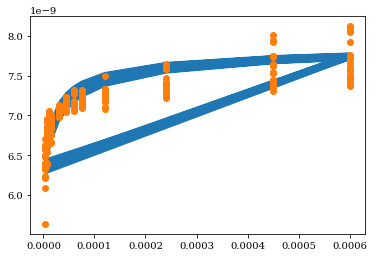

In [192]:
test = mod.eval(CT=CT, params=params)

#plt.plot(CT[:,0],test)
# plt.plot(CT[:,0],Ravgs,"o")

out = mod.fit(Ravgs, CT=CT, params=params)
print(out.fit_report())
plt.plot(CT[:,0], out.best_fit)
plt.plot(CT[:,0],Ravgs,"o")

[[Model]]
    Model(mon_tri)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 245
    # variables        = 2
    chi-square         = 2.9857e-17
    reduced chi-square = 1.2287e-19
    Akaike info crit   = -10666.0835
    Bayesian info crit = -10659.0810
[[Variables]]
    Rh1:  6e-09 (fixed)
    Rh2:  8e-09 (fixed)
    dH:  -46231.8878 +/- 14559.5190 (31.49%) (init = -200)
    dS:   15.0102776 +/- 48.0924912 (320.40%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(dH, dS) =  1.000



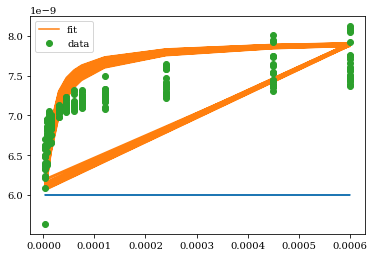

In [193]:
# monomer trimer model
mod = Model(mon_tri)

CT = np.vstack(list(zip(concs,Ts)))

Ravgs = np.array(Rhs)

params = dict(
    Rh1=6.0e-9,
    Rh2=8.0e-9,
    dH=-200,
    dS=1.0,
)

params = mod.make_params(**params)

params["Rh1"].vary = False
params["Rh2"].vary = False

test = mod.eval(CT=CT, params=params)
plt.plot(CT[:,0],test)

out = mod.fit(Ravgs, CT=CT, params=params)
print(out.fit_report())
plt.plot(CT[:,0],out.best_fit,label="fit")
plt.plot(CT[:,0],Ravgs,"o",label="data")
plt.legend()

[[Model]]
    Model(tri_hex)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 245
    # variables        = 2
    chi-square         = 1.2912e-17
    reduced chi-square = 5.3135e-20
    Akaike info crit   = -10871.4623
    Bayesian info crit = -10864.4598
[[Variables]]
    Rh1:  6e-09 (fixed)
    Rh2:  8e-09 (fixed)
    dH:  -12410.9360 +/- 6243.66366 (50.31%) (init = 1)
    dS:   39.7036832 +/- 20.6222118 (51.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(dH, dS) =  1.000



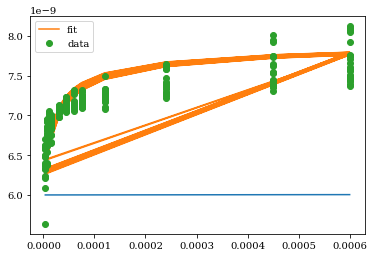

In [194]:
# trimer hexamer model
mod = Model(tri_hex)

CT = np.vstack(list(zip(concs,Ts)))

Ravgs = np.array(Rhs)

params = dict(
    Rh1=6.0e-9,
    Rh2=8.0e-9,
    dH=1.0,
    dS=1.0,
)

params = mod.make_params(**params)

params["Rh1"].vary = False
params["Rh2"].vary = False

test = mod.eval(CT=CT, params=params)
plt.plot(CT[:,0],test)

out = mod.fit(Ravgs, CT=CT, params=params)
print(out.fit_report())
plt.plot(CT[:,0],out.best_fit,label="fit")
plt.plot(CT[:,0],Ravgs,"o",label="data")
plt.legend()

In [195]:
# monomer trimer hexamer model
mod = Model(mon_tri_hex)

CT = np.vstack(list(zip(concs,Ts)))

Ravgs = np.array(Rhs)

params = dict(
    Rh1=5.5e-9,
    Rh2=6.0e-9,
    Rh3=8.0e-9,
    dH1=-4.0e5,
    dS1=-10,
    dH2=1.26e5,
    dS2=500,
)

params = mod.make_params(**params)
params["Rh1"].vary = False
params["Rh2"].vary = False
params["Rh3"].vary = False
params


name,value,initial value,min,max,vary
Rh1,5.5000e-09,None,-inf,inf,False
Rh2,6.0000e-09,None,-inf,inf,False
Rh3,8.0000e-09,None,-inf,inf,False
dH1,-400000.000,None,-inf,inf,True
dS1,-10.0000000,None,-inf,inf,True
dH2,126000.000,None,-inf,inf,True
dS2,500.000000,None,-inf,inf,True


[[Model]]
    Model(mon_tri_hex)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 245
    # variables        = 4
    chi-square         = 4.1223e-17
    reduced chi-square = 1.7105e-19
    Akaike info crit   = -10583.0521
    Bayesian info crit = -10569.0470
[[Variables]]
    Rh1:  5.5e-09 (fixed)
    Rh2:  6e-09 (fixed)
    Rh3:  8e-09 (fixed)
    dH1: -400000.000 +/- 1.1655e+11 (29138637.81%) (init = -400000)
    dS1: -10.0000000 +/- 2704083.19 (27040831.89%) (init = -10)
    dH2:  126000.000 +/- 12794.4133 (10.15%) (init = 126000)
    dS2:  500.000000 +/- 42.2641751 (8.45%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(dH2, dS2) =  1.000
    C(dH1, dS1) = -0.574



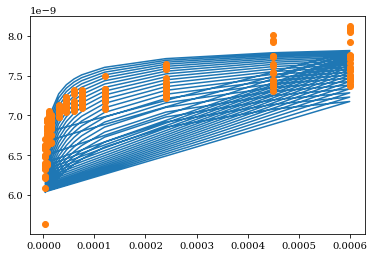

In [196]:
test = mod.eval(CT=CT, params=params)

#plt.plot(CT[:,0],test)
# plt.plot(CT[:,0],Ravgs,"o")

out = mod.fit(Ravgs, CT=CT, params=params)
print(out.fit_report())
plt.plot(CT[:,0], out.best_fit)
plt.plot(CT[:,0],Ravgs,"o")

In [202]:
# monomer trimer hexamer model
mod = Model(tri_hex_dod)

CT = np.vstack(list(zip(concs,Ts)))

Ravgs = np.array(Rhs)

params = dict(
    Rh1=5.5e-9,
    Rh2=6.0e-9,
    Rh3=8.0e-9,
    dH1=-136427.248,
    dS1=100,
    dH2=-26443.4968,
    dS2=1,
)

params = mod.make_params(**params)
params["Rh1"].vary = False
params["Rh2"].vary = False
params["Rh3"].vary = False
#params["dH1"].vary = False
params["dH2"].vary = False
params

name,value,initial value,min,max,vary
Rh1,5.5000e-09,None,-inf,inf,False
Rh2,6.0000e-09,None,-inf,inf,False
Rh3,8.0000e-09,None,-inf,inf,False
dH1,-136427.248,None,-inf,inf,True
dS1,100.000000,None,-inf,inf,True
dH2,-26443.4968,None,-inf,inf,False
dS2,1.00000000,None,-inf,inf,True


In [204]:
# test = mod.eval(CT=CT, params=params)

# plt.plot(CT[:,0],test)
# plt.plot(CT[:,0],Ravgs,"o")

# out = mod.fit(Ravgs, CT=CT, params=params)
# print(out.fit_report())
# #plt.plot(CT[:,0], out.best_fit)
# #plt.plot(CT[:,0],Ravgs,"o")